# Geographic data

This notebook provides a brief, glancing introduction to some challenges you might confront if you were interested in geographic questions, and wanted to extract, interpret, or visualize references to locations.

There are other ways of producing maps, including proprietary GIS software. But if you want a relatively lightweight solution, using open-source tools, Python can probably do what you need. You may need to install a few modules that aren't automatically distributed with Anaconda, but that's not (usually) a big problem -- and installing packages is also worth trying, just so you know how to do it.

We'll tackle three tasks:

1. Suppose you have a collection of texts, and want to know what places are mentioned. We'll use the Natural Language Toolkit to automatically extract place names.

2. Suppose you want to map those places. You need to translate place names into latitude and longitude coordinates; this is called *geocoding*. We'll use the Google Maps API to geocode a few place names. This can be done from within Python, which becomes handy if you need to geocode more than ten or fifteen places at a time. (If you really need to do a *lot,* you'll need a free API key.)

3. Finally, you need to draw a map and plot your data on the map. There are lots of ways to do this in Python; we'll explore one.

## 1. Named entity recognition (NER)

Suppose we want to extract place names from a text. One way to do that is with a "gazetteer," a dictionary of placenames. But that's not ideal. Your dictionary would have to be very large, and even then you would run into ambiguity with words like "Washington" and "Charlotte" (which could be people) or "Providence" and "Champaign," which could be common nouns that happened to get capitalized for religious or grammatical reasons. ("Champaign stretched all around.")

So the sophisticated way to approach this problem is Named Entity Recognition, which tries to use syntax to distinguish capitalized words that are people -- or just the first word in a sentence -- from those that represent places.

I've got to be honest with you: the accuracy of NER can be pretty spotty, especially when it's applied to text of a kind it wasn't trained on (say, prose from an earlier historical period). Real projects that care about accuracy tend to use some combination of NER and a gazetteer, plus a certain amount of tinkering or retraining, to get accuracy up in a tolerable range.

However, let's start by playing around with NER to see how it works. We'll use the Natural Language Toolkit (nltk), which is included in the Anaconda distribution of Python. Unfortunately the pieces aren't all included, so we'll need to get them. The first thing to do is to run the cell below:

In [6]:
import nltk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/rdubnic2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/rdubnic2/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rdubnic2/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /Users/rdubnic2/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Once the parts of nltk are loaded, we can see what they do. We'll start by breaking a sentence into words, then tag each word with its part-of-speech (POS)

In [7]:
text = "Congressional leaders want Mr. Nunes to recuse himself from an inquiry into Russian meddling during the 2016 election, saying he is too close to the White House."
words = nltk.word_tokenize(text)
tagged = nltk.pos_tag(words)
print(tagged)

[('Congressional', 'JJ'), ('leaders', 'NNS'), ('want', 'VBP'), ('Mr.', 'NNP'), ('Nunes', 'NNP'), ('to', 'TO'), ('recuse', 'VB'), ('himself', 'PRP'), ('from', 'IN'), ('an', 'DT'), ('inquiry', 'NN'), ('into', 'IN'), ('Russian', 'JJ'), ('meddling', 'NN'), ('during', 'IN'), ('the', 'DT'), ('2016', 'CD'), ('election', 'NN'), (',', ','), ('saying', 'VBG'), ('he', 'PRP'), ('is', 'VBZ'), ('too', 'RB'), ('close', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('White', 'NNP'), ('House', 'NNP'), ('.', '.')]


If you want to know the meaning of all the tags, consult [this key to the Penn Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). NNP, for instance, is a proper noun; VBD is a past-tense verb.

Having tagged the sentence, we can do some shallow parsing of relations between words, in order to group related words together, and characterize some chunks as named entities.

For a deeper understanding of what's going on here, see [Natural Language Processing with Python, by Bird et al.](http://www.nltk.org/book/ch07.html)

In [8]:
chunked = nltk.ne_chunk(tagged)
print(chunked)
print(type(chunked))
chunked.draw()

(S
  Congressional/JJ
  leaders/NNS
  want/VBP
  (PERSON Mr./NNP Nunes/NNP)
  to/TO
  recuse/VB
  himself/PRP
  from/IN
  an/DT
  inquiry/NN
  into/IN
  (GPE Russian/JJ)
  meddling/NN
  during/IN
  the/DT
  2016/CD
  election/NN
  ,/,
  saying/VBG
  he/PRP
  is/VBZ
  too/RB
  close/JJ
  to/TO
  the/DT
  (FACILITY White/NNP House/NNP)
  ./.)
<class 'nltk.tree.Tree'>


This weird sequence is an object of type nltk.Tree, as it admits at the bottom.

If you examine the parentheses, you can see that some words have been grouped as a "PERSON" or as a geopolitical entity "GPE." If you look on your desktop you'll also find a window where the relations between words have been graphed as a tree. (This is accomplished by the draw() method of nltk.Tree objects.) You'll need to close that window before Jupyter can proceed.

Of course, these tree objects aren't the most convenient things in the world to manipulate. Really, we just want the parts that are tagged GPE. Here's a function that extracts them as a list. I've cheated a bit by including "ORGANIZATION"s as well as GPEs; I observed that nltk often gets these confused.

In [9]:
# function for navigating an object of type nltk.Tree,
# in order to extract places

# The code here is adapted from a Stack Overflow answer by alvas
# http://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list

def get_placenames(parsed_tree):
    prev = None
    continuous_chunk = []
    current_chunk = []
    place_labels = {'GPE', 'GSP', 'FACILITY', 'ORGANIZATION'}
    for node in parsed_tree:
        if type(node) == nltk.Tree and (node.label() in place_labels):
            current_chunk.append(" ".join([token for token, pos in node.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    return continuous_chunk

print(get_placenames(chunked))

['Russian', 'White House']


Now that we've got all the pieces, let's see what they can do with a longer chunk of text, like this one from *Moby-Dick.*

In [10]:
text = ' '.join(["I stuffed a shirt or two into my old carpet-bag, tucked it ",
        "under my arm, and started for Cape Horn and the Pacific. Quitting ",
        "the good city of old Manhatto, I duly arrived in New Bedford. ",
        "It was a Saturday night in December. Much was I disappointed ",
        "upon learning that the little packet for Nantucket had already sailed, ",
        "and that no way of reaching that place would offer, till the following ",
        "Monday. As most young candidates for the pains and penalties of whaling ",
        "stop at this same New Bedford, thence to embark on their voyage, it may ",
        "as well be related that I, for one, had no idea of so doing. For ",
        "my mind was made up to sail in no other than a Nantucket craft, ",
        "because there was a fine, boisterous something about everything ",
        "connected with that famous old island, which amazingly pleased me. ",
        "Besides though New Bedford has of late been gradually monopolising ",
        "the business of whaling, and though in this matter poor old Nantucket ",
        "is now much behind her, yet Nantucket was her great original - the Tyre ",
        "of this Carthage;—the place where the first dead American whale was ",
        "stranded. Where else but from Nantucket did those aboriginal whalemen, ",
        "the Red-Men, first sally out in canoes to give chase to the Leviathan? ",
        "And where but from Nantucket, too, did that first adventurous little sloop ",
        "put forth, partly laden with imported cobblestones - so goes the story - ",
        "to throw at the whales, in order to discover when they were nigh enough ",
        "to risk a harpoon from the bowsprit?"])

sentences = nltk.sent_tokenize(text)
# print(sentences)
# print(text)

# Before we proceed to word_tokenize, we break the block of text into 
# a list of sentences. The tagging and chunking processes tend to work
# better on strings that are single sentences.

# Then we loop through the sentences, tagging and chunking each one,
# extracting placenames, and adding those to a growing list of
# moby_places. Note that "extend" is like "append" but appends
# all the elements of a list.

moby_places = []

for s in sentences:
    words = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(words)
    namedEnt = nltk.ne_chunk(tagged)
    chunks = get_placenames(namedEnt)
    moby_places.extend(chunks) # takes a list of things and adds all list items to the end of another list

print('\nPLACENAMES: ')
print(moby_places)


PLACENAMES: 
['Pacific', 'New Bedford', 'New Bedford', 'New Bedford', 'Tyre', 'Carthage', 'American', 'Leviathan', 'Nantucket']


There are some errors in there, and some things that got missed (e.g. Cape Horn, Manhattan). But it's not completely awful. At least we don't have Saturday or December included as places.

## Geocoding with the Google API

Suppose we wanted to plot the places from *Moby-Dick* on a map. To do that we need to know where they are. Translating a place name into latitude and longitude coordinates is called "geocoding." There are a number of web services out there that will help you do that. These are examples of APIs (application programming interfaces) -- basically, protocols that you can use to allow your program to communicate with / delegate to other programs.

While we *could* send information to the web using generic Python modules, it becomes a lot easier if you use a module custom-built for geocoding. Let's use **geopy.** To load this you would ordinarily go to the command line and say

    > conda install geopy
    
But geopy is unusual in not being available through conda. So you need to use another package manager, ```pip.``` Say

    > conda install pip
    
and then

    > pip install geopy

Then you can run the cell below.

In [11]:
import geopy, time
api = geopy.geocoders.GoogleV3()
result, (lat, lng) = api.geocode("Anfield")
print(result)
print(lat, lng)

Anfield Rd, Liverpool L4 0TH, UK
53.4308294 -2.96083


The Google Maps API is pretty good at inferring information from the limited clues we gave it. Let's see what it can do with the list of ```moby_places``` we extracted from *Moby-Dick.* Note that I've inserted a command to sleep for one second in each iteration of the loop, because the Google API does not like to be rushed by people who aren't paying customers.

Note also that we record longitude, latitude tuples in a list of ```allcoordinates``` for future use.

And finally, you may want to notice the *error handling* statements I have used in the code snippet below. A lot of things can go wrong when you call the web; we don't want a single glitch to stop our whole job.

In [12]:
allcoordinates = []

for placename in moby_places:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        allcoordinates.append((lng, lat))
    except:
        print('Could not find: ' + placename)

Could not find: Pacific
New Bedford:  New Bedford, MA, USA
41.6362152 -70.93420499999999
New Bedford:  New Bedford, MA, USA
41.6362152 -70.93420499999999
New Bedford:  New Bedford, MA, USA
41.6362152 -70.93420499999999
Could not find: Tyre
Carthage:  Carthage, Tunisia
36.8625853 10.3329494
Could not find: American
Could not find: Leviathan
Nantucket:  Nantucket, MA, USA
41.2834704 -70.099451


## Visualizing space

Maps provide great visuals; the ability to translate an argument into a map is much of the fun of working with spatial data. If you want to do that in a maximally polished and flexible way, you may want special-purpose GIS tools. But for many scholarly arguments, Python can do what you need. There are several different modules we could use, but let's explore ```basemap```, which plays nicely with matplotlib. Unfortunately, it's not built into Anaconda, so you need to go to the control line and say 

    conda install basemap

before continuing.

Then you should be able to run the cell below. The code here, and in subsequent cells of this notebook, is adapted from [the basemap documentation.](http://matplotlib.org/basemap/users/geography.html)

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


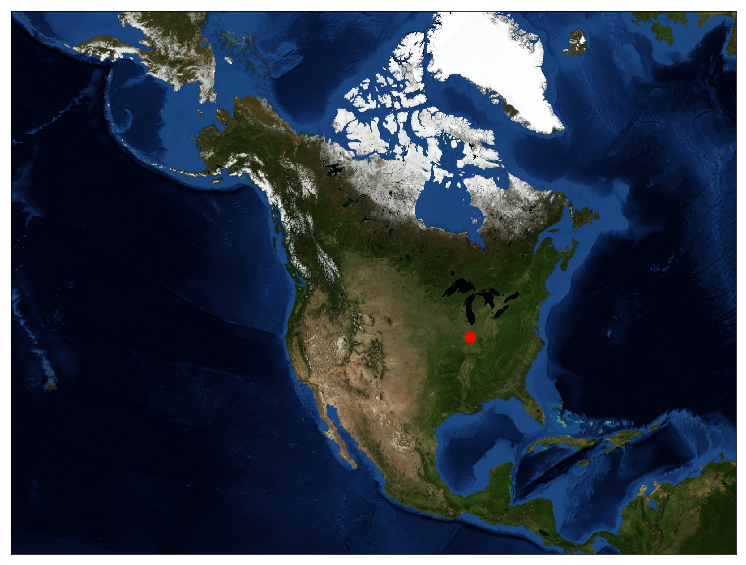

In [13]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
plt.figure(figsize=(20,10))
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.bluemarble()

m.plot(-88.2316213, 40.1077795, 'ro', markersize = 10, latlon = True)
# That's our way of saying "hi, mom!"

plt.show()

That map will take some time to display, and for certain kinds of arguments the landform colors may actually be distractions. So there are more Spartan options available.

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


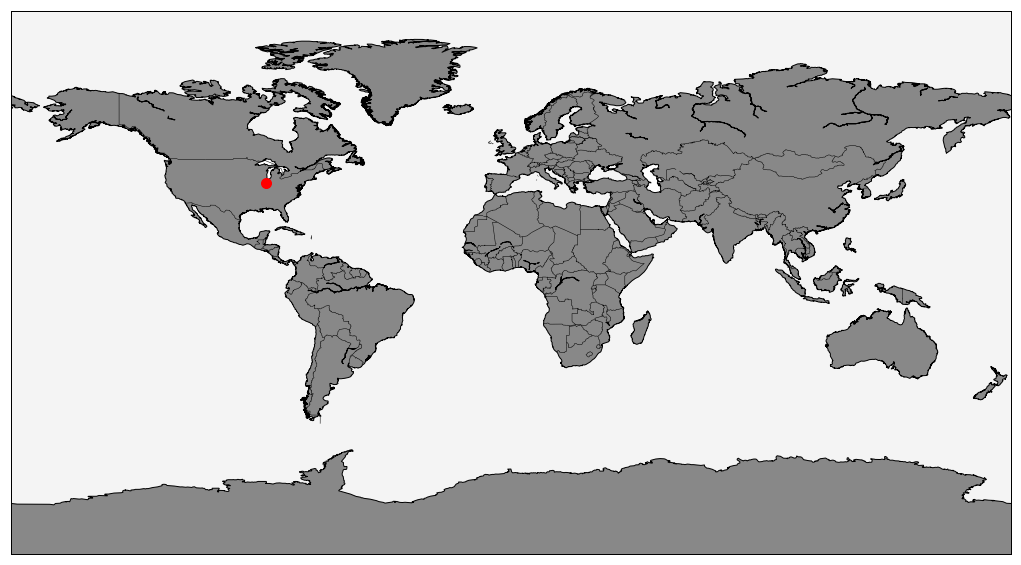

In [14]:
# Create a big canvas.
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')
    
map.plot(-88.2316213, 40.1077795, 'ro', markersize = 10, latlon = True)

# Show the map
plt.show()


### Exercise 1.

Remember how we stored the coordinates for all the places mentioned at the beginning of Chapter 2 of *Moby-Dick*? The list is in allcoordinates.

In [15]:
print(allcoordinates)


[(-70.93420499999999, 41.6362152), (-70.93420499999999, 41.6362152), (-70.93420499999999, 41.6362152), (10.3329494, 36.8625853), (-70.099451, 41.2834704)]


Use that list to create a map where all the spots mentioned in that part of *Moby-Dick* appear as red dots. You can just copy the Gall-Peters example above (the gray map), and add a loop that plots the locations.

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Counter({(-70.93420499999999, 41.6362152): 3, (-70.099451, 41.2834704): 1, (10.3329494, 36.8625853): 1})
1
1
3


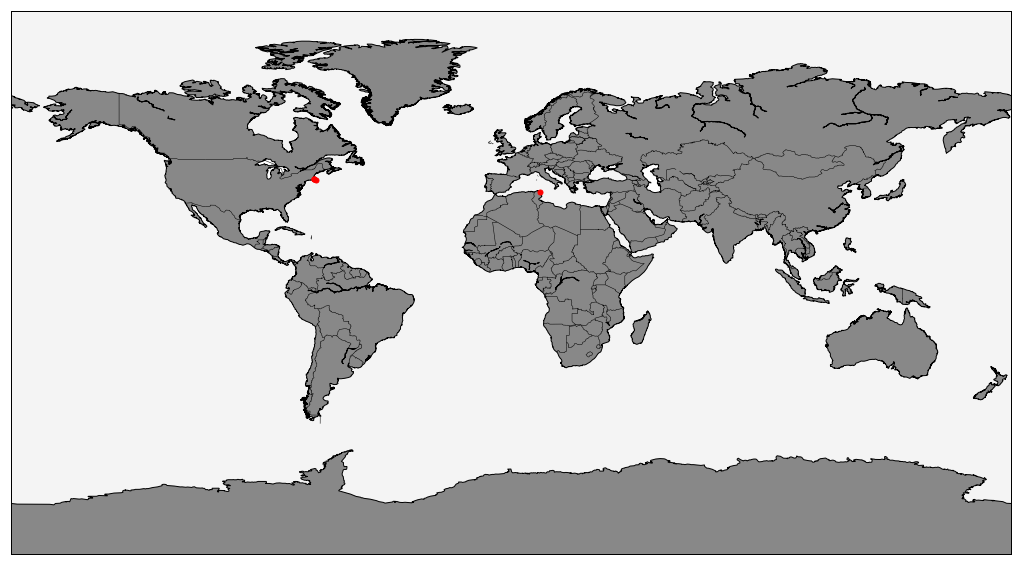

In [16]:
# code for Exercise 1 goes here
import math

# Create a big canvas.
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

from collections import Counter

occurrences = Counter(allcoordinates)
print(occurrences)

for pair, count in occurrences.items():
    lon, lat = pair
    num_count = count
    print(num_count)
    
for lon, lat in allcoordinates:
    # print(lon, lat)
    map.plot(lon, lat, 'ro', markersize = 5, latlon = True)


### Exercise 2

Let's make that a little more complicated. New Bedford actually appears three times in the passage; it ought to appear larger than the other places.

Write code that makes the area of the marker proportional to the number of times a place is mentioned. (Since ```markersize``` controls diameter, and area is proportional to diameter squared, this means that you'll want ```markersize``` to be proportional to the *square root* of the number of times a place is mentioned.)

Some hints about that part:

    > import math
    > math.sqrt(4)
    2.0

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Counter({(-70.93420499999999, 41.6362152): 3, (-70.099451, 41.2834704): 1, (10.3329494, 36.8625853): 1})
1
1
3


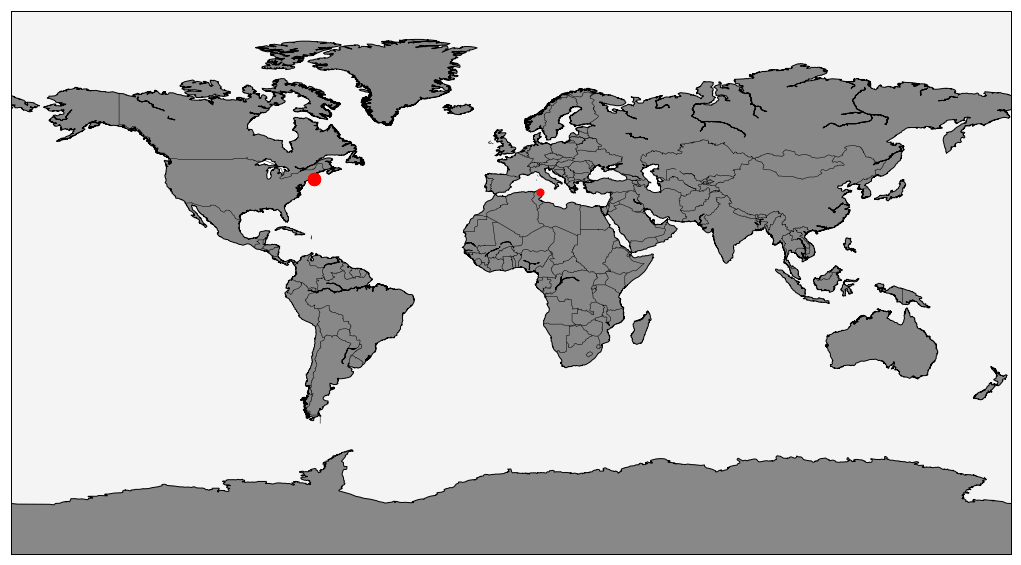

In [18]:
# code for exercise 2
import math

# Create a big canvas.
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

from collections import Counter

occurrences = Counter(allcoordinates)
print(occurrences)

for pair, count in occurrences.items():
    lon, lat = pair
    num_count = count
    print(num_count)
    
for lon, lat in allcoordinates:
    # print(lon, lat)
    map.plot(lon, lat, 'ro', markersize = (math.sqrt(50*occurrences[lon,lat])), latlon = True)


### Postscript

In case you need a political map of the United States, there's an example below. For much more impressive examples of geophysical data plotted using this package, see [the basemap documentation.](http://matplotlib.org/basemap/users/examples.html)

Humanists often want to use historical maps, or overlay them on a modern geographic grid, which can be quite a bit more complex; see [this blog post by Lincoln Mullen about "georectification."](http://lincolnmullen.com/projects/spatial-workshop/georectification.html)

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


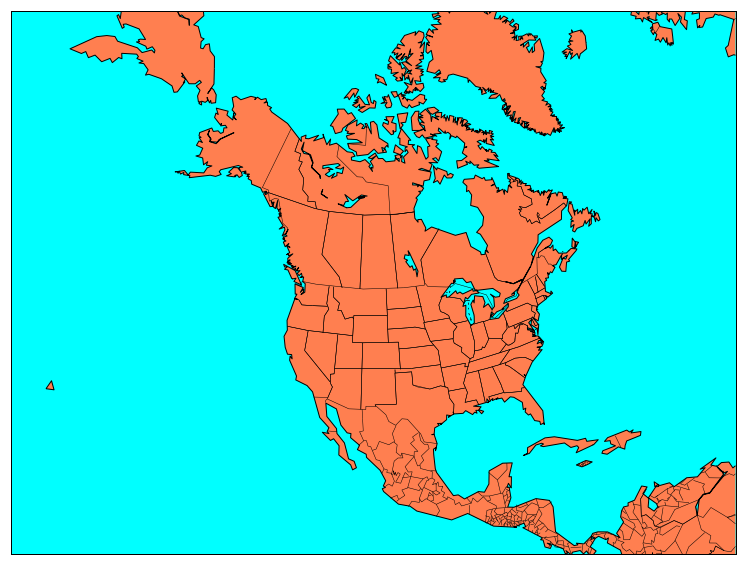

In [19]:
plt.figure(figsize=(20,10))

# setup Lambert Conformal basemap.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcountries()
m.drawstates()
    
plt.show()

## Homework

Find a text that interests you — any text, fiction or nonfiction. (You can find many books on Gutenberg or Hathi. A short story or essay would be plenty long enough. If you're stumped, I've placed a story by H. P. Lovecraft in the assignment folder — he often has legible geographical obsessions.) Then reproduce the steps we traced above to extract placenames from the text you have chosen. Geocode those places with the Google API, then plot them on a world map.

But before you start geocoding up a storm, let's improve our extraction methods a bit.

When you're working with a long text, you will probably find that the number of errors is so high that it becomes really intolerable. Lots of personal names or even common capitalized words are misrecognized as places. We could probably improve this by using the Stanford Named Entity Recognizer, which is better than the default nltk version. But that involves some nasty details (Java, cough). And in any event, it wouldn't solve the problem as well as human intervention. Instead, let's borrow Matt Wilkens' gazetteer of place names and things-that-aren't-places. It's available on our Moodle page, and is described at more length on [The Uses of Scale.](https://usesofscale.com/gritty-details/geolocation-correction/)

Use Wilkens' gazetteer to filter the placenames you extracted from your text before geocoding them. You'll probably want to ignore proper nouns that he says should be ignored. You might also want to ignore *everything* that isn't included in the gazetteer (that would get rid of a lot of personal names), and/or use the gazetteer to *translate* archaic or ambiguous terms into "aliases" that are more useful for geocoding. Here's a glance at the data (notice that I need to use sep = '\t' to read this tab-separated file.)

I haven't explained how exactly you would use this table to "filter" and "translate" your list; that's the off-road coding part of the assignment. Start by trying to think the process through step-by-step; there is no single magic codeword that will do it all at once. When you get stuck, try googling solutions for the particular places where you're stuck. If still stuck, try the Moodle discussion forum, or email me.

If you like, you can end the notebook with a sentence or two interpreting any patterns you find. But it's not essential to find patterns! The geographical references in a single story or essay might not really be very revealing or surprising; this is a method that tends to pay off at larger scales of analysis.

In [20]:
import pandas as pd
wilkens = pd.read_csv('/Users/rdubnic2/Documents/lis590dsh/Data/place_strings_reviewed.tsv', sep = '\t')
wilkens.head(20)

,string,occurrences,volumes,authors,ignore,alias,comment
0,Abbey,30,10,10,1,NaN,NaN
1,Abbotsford,7,6,5,0,"Melrose, UK","Melrose, UK"
2,Abelard,6,4,4,1,NaN,NaN
3,Abraham,17,11,9,1,NaN,NaN
4,ABYDOS,11,8,8,0,"Canakkale, Turkey","No longer exists; closest is Canakkle, Turkey"
5,Abyssinia,10,7,7,0,Ethiopia,NaN
6,Acapulco,19,6,6,0,NaN,NaN
7,Ackland,5,2,2,1,NaN,NaN
8,Acropolis,25,8,8,0,NaN,NaN
9,Acton,45,4,4,0,NaN,NaN


In [21]:
lovefile = open('/Users/rdubnic2/Documents/lis590dsh/Data/LovecraftCharlesDexter1927.txt', 'r')
lovecraft_file = lovefile.read()

lovecraft = ''.join(lovecraft_file)

love_words = nltk.word_tokenize(lovecraft)
tagged = nltk.pos_tag(love_words)

love_places2 = []

namedEnt = nltk.ne_chunk(tagged)
print(len(chunked))
print(type(chunked))
# chunked.draw()

chunks = get_placenames(namedEnt)
love_places2.extend(chunks) # takes a list of things and adds all list items to the end of another list

print('\nPLACENAMES: ')
# print(love_places2)

27
<class 'nltk.tree.Tree'>

PLACENAMES: 


In [1]:
wilkens_true_df = wilkens.drop(wilkens[wilkens.ignore > 0].index)
# print('Things in wilkens_true_list:', len(wilkens_true_df))

wilkens_places = wilkens_true_df['string'].tolist()
# print('Places in wilkens_places:',len(wilkens_places))
# print(wilkens_places)

loveplaces_filtered = []

for word in love_places2:
    if word in wilkens_places:
        loveplaces_filtered.append(word)
        
# print('Places in lovecraft_places after comparing wilkens_places:', len(lovecraft_places))

print('\nFILTERED LOVECRAFT PLACENAMES: ', len(loveplaces_filtered))
print(loveplaces_filtered)

lovecraft_coords = []

for placename in loveplaces_filtered:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        lovecraft_coords.append((lng, lat))
    except:
        print('Could not find: ' + placename)

print('Coordinates in lovecraft_coords: ', len(lovecraft_coords))

In [22]:
# wilkens_true_df = wilkens.drop(wilkens[wilkens.ignore > 0].index)
# print('Things in wilkens_true_df:', len(wilkens_true_df))

wilkens_ignore_df = wilkens.drop(wilkens[wilkens.ignore < 1].index)
# print('Things in wilkens_ignore_df', len(wilkens_ignore_df))

wilkens_ignore = wilkens_ignore_df['string'].tolist()
print('Places in wilkens_ignore:',len(wilkens_ignore))

lovecraft_places7 = []

print('ORIGINAL NUMBER OF PLACES IN LOVECRAFT: ', len(love_places2))

for word in love_places2:
    if word not in wilkens_ignore:
        lovecraft_places7.append(word)
        
print('Places in lovecraft_places after comparing wilkens_places:', len(lovecraft_places7))

print('\nLOVECRAFT PLACENAMES: ', len(lovecraft_places7))

# print(lovecraft_places7)        

lovecraft_coords2 = []

for placename in lovecraft_places7:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        # print(placename + ":  " + fullname)
        # print(lat, lng)
        lovecraft_coords2.append((lng, lat))
    except:
        print('Could not find: ' + placename)

print('Coordinates in lovecraft_coords2: ', len(lovecraft_coords2))


Places in wilkens_ignore: 1408
ORIGINAL NUMBER OF PLACES IN LOVECRAFT:  540
Places in lovecraft_places after comparing wilkens_places: 514

LOVECRAFT PLACENAMES:  514


In [17]:
lovefile = open('/Users/rdubnic2/Documents/lis590dsh/Data/LovecraftCharlesDexter1927.txt', 'r')
lovecraft = lovefile.read()
type(lovecraft)

words = nltk.word_tokenize(text)
tagged = nltk.pos_tag(words)

lovewords = nltk.word_tokenize(lovecraft)
# print('Words in lovewords:',len(lovewords))

wilkens_true_df = wilkens.drop(wilkens[wilkens.ignore > 0].index)
print('Things in wilkens_true_df:', len(wilkens_true_df))

wilkens_ignore_df = wilkens.drop(wilkens[wilkens.ignore < 1].index)
print('Things in wilkens_ignore_df', len(wilkens_ignore_df))

wilkens_places = wilkens_true_df['string'].tolist()
# print('Places in wilkens_places:',len(wilkens_places))

# print('Location of "St." in wilkens_places:', wilkens_places.index('St.'))
# print('Location of "west" in wilkens_places:',wilkens_places.index('west'))

del wilkens_places[1581] # manually removing 'St.' which throws off results
del wilkens_places[1751] # manually removing 'west' which throws off results

#cprint('Places in wilkens_places:',len(wilkens_places))

# print(wilkens_places)

lovecraft_places = []
for word in lovewords:
    if word in wilkens_places:
        lovecraft_places.append(word)
        
# print('Places in lovecraft_places after comparing wilkens_places:', len(lovecraft_places))

print('\nLOVECRAFT PLACENAMES: ', len(lovecraft_places))

# print(lovecraft_places)

for place in lovecraft_places:
    if place == 'west': # truly manually removing 'west', which doesn't go away with del command
        lovecraft_places.remove(place)
        
# print(lovecraft_places)

lovecraft_coords = []

# for placename in lovecraft_places:
#     time.sleep(1)
#     try:
#         fullname, (lat, lng) = api.geocode(placename)
#         print(placename + ":  " + fullname)
#         print(lat, lng)
#         lovecraft_coords.append((lng, lat))
#     except:
#         print('Could not find: ' + placename)

print('Coordinates in lovecraft_coords: ', len(lovecraft_coords))


LOVECRAFT PLACENAMES:  152
Coordinates in lovecraft_coords:  0


/Users/rdubnic2/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


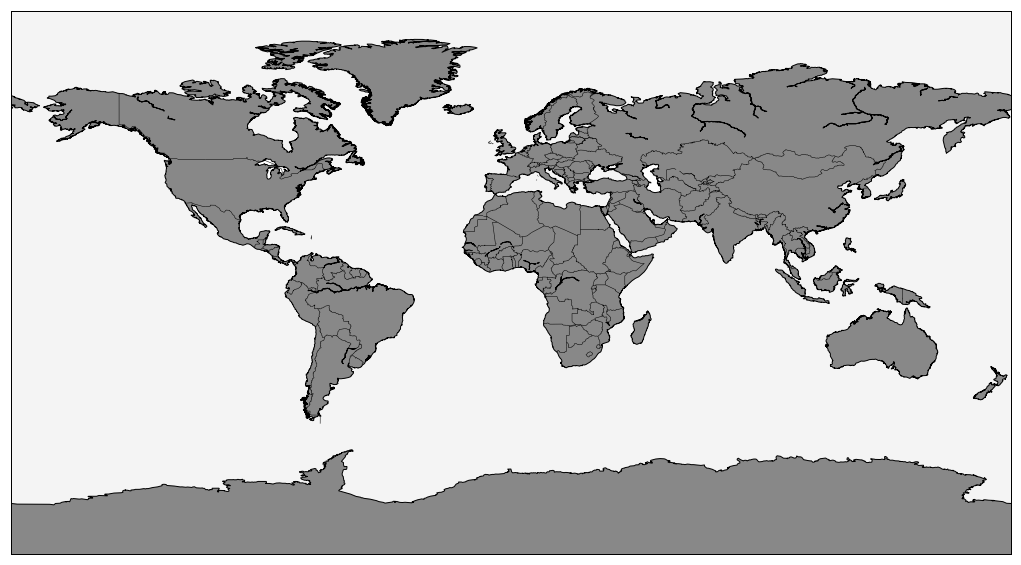

In [30]:
import math

# Create a big canvas.
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

from collections import Counter

occurrences = Counter(lovecraft_coords)
# print(occurrences)

for pair, count in occurrences.items():
    lon, lat = pair
    num_count = count
    # print(num_count)
    
for lon, lat in lovecraft_coords:
    # print(lon, lat)
    map.plot(lon, lat, 'ro', markersize = (math.sqrt(15*occurrences[lon,lat])), latlon = True)

## Analysis

Not knowing anything about this Lovecraft story, I would guess it it's about shipping or someone who travels by boat, as the places mentioned seem largely coastal/port cities. I know very little about Lovecraft, but have read "Call of Cthulu" and "Shadows over Innsmouth," and he tends to be very ocean-focused, though perhaps no more so than someone who grew up in New England during his time. So, this guess logically follows from the map's results and what little I know of him. 

Even if this hypothesis is wrong, it's a really cool way to visualize place names in a text, and I think it quickly opens up the possibility of thematic discovery "at a glance." I can think of the genre of the road novel, and some interesting analysis to be done about whether the road novel has more place names, or less, have certain places in common, or are more about movement--i.e. contrast in place location--than visiting/mentioning places.

Beyond the visualization, being able to reliably extract place names and geolocate them (essentially verify them) has some great implications for text analysis generally. I imagine some interesting conclusions to come out of being able to gauge characterization of countries, races or religions by identifying place names in a text, and then running sentiment analysis on the ~50 words either side of the place to get an idea of how certain locations are spoken of in fiction.